In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim




In [2]:
torch.cuda.device_count()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


In [6]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, 
                                      transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

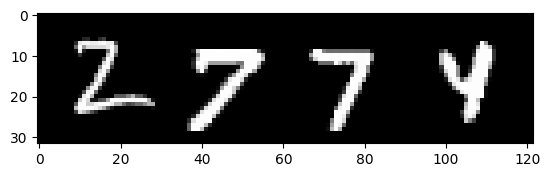

2 7 7 4


In [7]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(str(classes[labels[j].item()]) for j in range(4)))

Simple MLP model   

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
net = SimpleNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


Simple CNN Model 

In [73]:
class FirstCNN(nn.Module):
    def __init__(self): 
        super(FirstCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=(1,1), stride=(2,2)) # 3=depth of input, 16=depth of output, padding=(1,1), stride=(2,2))
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.to(device)
        x = self.conv1(x)
        x =self.relu(x)

        return x

In [74]:
conv_net=FirstCNN().to(device)

In [75]:
out = conv_net(images)
out.shape

torch.Size([4, 16, 14, 14])

In [25]:
def evaluation(dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

Train and Evaluate through Simple MLP

Epoch: 1/5, Test acc: 94.85, Train acc: 96.05
Epoch: 2/5, Test acc: 95.21, Train acc: 96.17
Epoch: 3/5, Test acc: 95.26, Train acc: 96.33
Epoch: 4/5, Test acc: 95.04, Train acc: 96.25
Epoch: 5/5, Test acc: 94.85, Train acc: 96.41


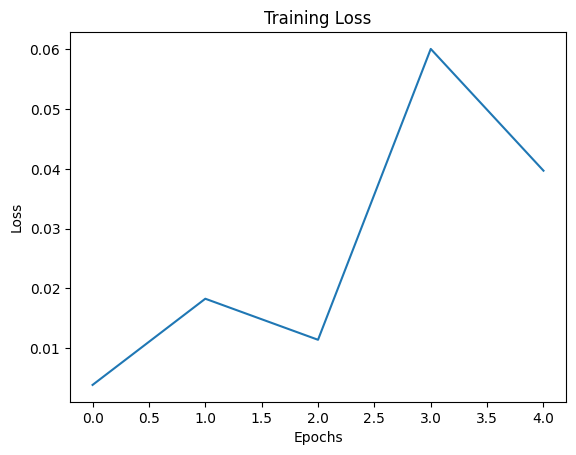

CPU times: user 4min 25s, sys: 41.2 s, total: 5min 6s
Wall time: 5min 34s


In [26]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 5

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch + 1, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Train and evaluate through through simple CNN

In [77]:
print(labels.shape)

torch.Size([4])


In [76]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 5

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = conv_net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.item())
    loss_epoch_arr.append(loss.item())
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch + 1, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [4]

# Active Learning part

Step 1: Calculate the entropy of the model's predictions for the unlabeled dataset.

Step 2: Select the top "k" samples with the highest entropy for labeling.

Step 3: Label the selected samples and add them to the labeled dataset.

Step 4: Retrain the model on the updated labeled dataset.

In [28]:
# Acquisition function
def entropy(p):
    return -torch.sum(p * torch.log2(p), dim=1)

In [29]:
# Active learning loop
max_iterations = 2
num_labeled_samples = 200
acquisition_batch_size = 20 # highest uncertainty point in each iteration.

In [30]:
# Step 2 and Step 3

labeled_indices = np.random.choice(len(trainset), num_labeled_samples, replace=False)
unlabeled_indices = list(set(range(len(trainset))) - set(labeled_indices))
labeled_dataset = torch.utils.data.Subset(trainset, labeled_indices)
unlabeled_dataset = torch.utils.data.Subset(trainset, unlabeled_indices)

In [42]:
labeled_indices.shape
len(unlabeled_indices)

59680

In [47]:
# Active learning Function 

def active_learning(max_iterations, acquisition_batch_size):

    labeled_indices = np.random.choice(len(trainset), num_labeled_samples, replace=False)
    unlabeled_indices = list(set(range(len(trainset))) - set(labeled_indices))
    labeled_dataset = torch.utils.data.Subset(trainset, labeled_indices)
    unlabeled_dataset = torch.utils.data.Subset(trainset, unlabeled_indices)
    for iteration in range(max_iterations):
        print(f"\nActive Learning Iteration {iteration + 1}/{max_iterations}")

        # Calculate model predictions and entropy for the unlabeled dataset
        predictions = []
        with torch.no_grad():
            for data in unlabeled_dataset:
                inputs, _ = data
                inputs = inputs.to(device)
                outputs = net(inputs.unsqueeze(0))
                predictions.append(outputs.softmax(dim=1))
        entropies = entropy(torch.cat(predictions))
        entropies = entropies.cpu()

        # Select the top samples with highest entropy for labeling
        top_indices = np.argsort(entropies)[-acquisition_batch_size:]
        labeled_indices = np.concatenate((labeled_indices, np.array(unlabeled_indices)[top_indices]))
        unlabeled_indices = list(set(unlabeled_indices) - set(np.array(unlabeled_indices)[top_indices]))

        # Update labeled and unlabeled datasets
        labeled_dataset = torch.utils.data.Subset(trainset, labeled_indices)
        unlabeled_dataset = torch.utils.data.Subset(trainset, unlabeled_indices)

        # Train the model on the updated labeled dataset
        for epoch in range(2):  
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

        test_accuracy = evaluation(testloader)
        print(f"Test Accuracy: {test_accuracy:.2f}%")





In [48]:
active_learning(max_iterations, acquisition_batch_size)



Active Learning Iteration 1/2
Test Accuracy: 95.18%

Active Learning Iteration 2/2
Test Accuracy: 95.09%


In [49]:
final_test_accuracy = evaluation(testloader)
print(f"\nFinal Test Accuracy: {final_test_accuracy:.2f}%")


Final Test Accuracy: 95.09%
